# Classification using Neural Networks (from scratch)

This notebook presents an implementation of feedforward neural networks and their training "from scratch", in order to understand all the steps involved in the process. The material is adapted from https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/ml_6_nn.ipynb
At this stage, we do not add any form of regularization (early stopping in the minimization, dropout, weight decay, etc.) and do not separate the train set into an actual training set and a validation set. This will be done in the next notebook, when we actually use neural networks to classify the MNIST digits.

**There are 8 questions to answer.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set up the random number generator: given seed for reproducibility
my_seed = 1
np.random.seed(my_seed)

## Creation of the dataset

We consider a binary classification problem with output space $\mathcal{Y} = \{-1,1\}$. We work with a synthetic dataset in dimension $d_0=2$, obtained from sampling on half circles with random radii, one of the circles being reflected around the horizontal axis and moved down, in order for the two subpopulations to be closer to one another.

The datapoints are returned in the format of matrix, with two lines and as many columns as datapoints. This corresponds to stacking the elements of the dataset (two dimensional column vectors) one after the other.

In [ ]:
noise_level = 0.1

def rescale(u,a,b,a1,b1):
    return a1 + (u-a)*(b1-a1)/(b-a)

def gen_point(m):
  y = np.sign(np.random.randn(1,m))
  x = np.zeros((2,m))
  r = 1 + noise_level*np.random.rand(m) # random radius, uniformly drawn between 1 and 1.1
  t = np.pi/2 + np.pi*np.random.rand(m) # random angle between pi/2 and 3*pi/2
  x[0,:] = r * np.sin(t)
  x[1,:] = r * np.cos(t)
  # reflect and shift for points with negative values of y
  I = (y.flatten()<0)
  x[0,I] = x[0,I] + 1
  x[1,I] = -.7-x[1,I]
  # rescale within a box of prescribed size
  x[0,:] = rescale(x[0,:],-1,2, .2,.8)
  x[1,:] = rescale(x[1,:],-1,.6,.2,.8)
  return x, y

We next display the data points $(x_i,y_i)_{1 \leqslant i \leqslant n}$ using a scatter plot for $x^i \in \mathbb{R}^2$, with a color depending on the value of $y_i$. We also generate a test set.

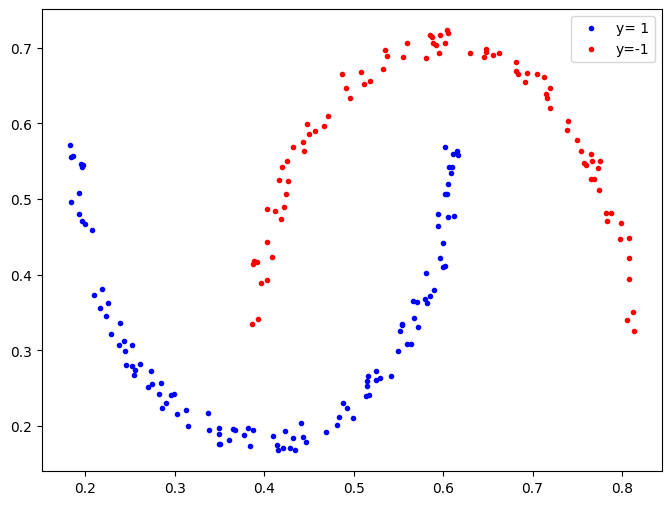

In [ ]:
# number of points
n = 200
# training set
x, y = gen_point(n)
# test set
x_test, y_test = gen_point(n)

# plotting the training set
plt.figure(figsize=(8,6))
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.',label='y= 1')
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.',label='y=-1')
plt.legend()
plt.show()

## Defining the loss function

$\newcommand{\RR}{\mathbb{R}}$
We consider a network $\phi_\theta$ composed of $L-1$ hidden layers of dimensions $(d_1,\dots,d_{L-1})$, with an input of dimension $d_0$ and an output of dimension $d_L$. It operates by initializing $x_0=x$ and iterating
$$
\forall \ell=1,\ldots,L, \qquad a_{\ell} := \rho(W_\ell a_{\ell-1} + b_\ell).  
$$
The function $\rho : \RR \to \RR$ is a nonlinear activation function which operates componentwise (and could be different from one layer to the other). The intermediate variables are $a_\ell \in \RR^{d_\ell}$ with $d_0 = 2$ (the dimension of the input) and $d_L=1$ (the dimension of the ouput). The matrices have sizes $W_\ell \in \RR^{d_{\ell} \times d_{\ell-1}}$, while the biases have sizes $b_\ell \in \RR^{d_{\ell}}$. The parameters of the networks are $\theta := (W_\ell,b_\ell)_{1 \leqslant \ell \leqslant L}$.

The predicted value $x_L = \phi_\theta(x)$ is used to compute the parameter $p(x)$ of a Bernoulli distribution using the sigmoid function, as
$$
p(x) = \sigma(\phi_\theta(x)) = \frac{\exp(\phi_\theta(x))}{1+\exp(\phi_\theta(x))}.
$$
The probability that the output $y$ associated with $x$ is 1 is $p(x)$, while the probability that it is -1 is $1-p(x)$. The likelikood of observing $y$ given $x$ is therefore
$$
\displaystyle P_\theta(y|x) = \frac{1}{1+\exp(-y \phi_\theta(x))}.
$$

**Question 1.** *Show that the maximization of the log-likelihood amounts to minimizing the empirical loss:
$$
\min_{\theta} \frac{1}{n} \sum_{i=1}^n \ell(y_i,\phi_\theta(x_i)), \qquad \ell(z,y) = \log( 1 + \exp(-y z) ).
$$
Compute also the partial derivative $\partial_z \ell(z,y)$.*

**Question 2.** Complete the code below to implement the loss function and its derivative. Note that in practice the loss function and its derivative are computed in parallel over a vector of labels $y \in \RR^{1 \times n}$, and an array $X$ of size $(2,n)$ of $n$ points in $\RR^2$ to which one will apply the neural network in order to obtain a vector of predicted labels $z = \phi_\theta(x) \in \RR^{1 \times n}$. The arguments $y,z$ in the code below are therefore vectors of sizes $1 \times n$, and the gradient to be computed should also be a vector of size $1 \times n$.

In [ ]:
# recall that the * product between two vectors corresponds to a componentwise product
def Loss(y,z):
    return 1/y.shape[1] * np.sum( np.log( 1 + np.exp(-y*z) ) )

def nablaLoss(y,z):
    return -1/y.shape[1] * y * np.exp(-y*z) / ( 1 + np.exp(-y*z) )

## Building the Network

We first define the activation function we use; here an atan sigmoid function. Results would not change much with other activation functions.

**Question 3.** Complete the second function, which computes the derivative of the activation function.

In [ ]:
def rho(u):
    return np.arctan(u)

def rhoG(u):
    return 1/(1+u**2)

The activation function can be displayed in order to gain some intuition on its typical scale of variation.

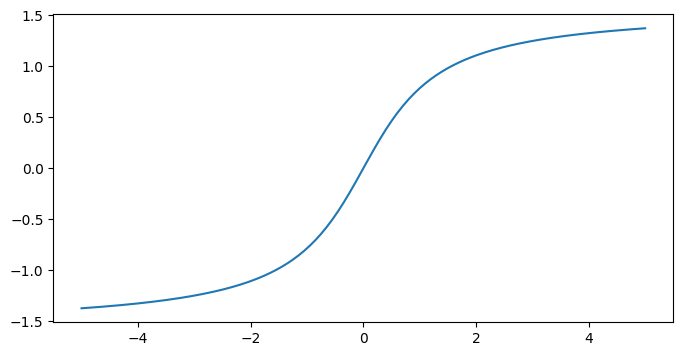

In [ ]:
t = np.linspace(-5,5,201)
plt.figure(figsize=(8,4))
plt.plot(t, rho(t))
plt.show()

We can now initialize the topology of the network, *i.e.* provide an array with the dimensions of the various layers. We start by considering a single hidden layer.

In [ ]:
dim_hidden_layer = 5
D = np.array([2,dim_hidden_layer,1])

All weights and biases are randomly initialized with standard Gaussians (*i.e.* we do not renormalize their scale depending on the number of incoming and outgoing connections).

In [ ]:
L = D.size-1
W = [] # list of weights
b = [] # list of biases
for l in np.arange(0,L):
    W.append(np.random.randn(D[l+1],D[l]))
    b.append(np.random.randn(D[l+1],1))

We next define the function which evaluates the network. There is some bookkeeping for the intermediate results, which is crucial for the subsequent computation of the gradient. The final output is the last element of the list $a$, which can be accessed as $a[-1]$.

In [ ]:
# format of input x = vector with 2 lines and n columns, i.e. the data points are stacked one after the other
def ForwardNN(W,b,x,L):
    a = []
    a.append(x)
    for l in np.arange(0,L):
        # matrix multiplication is performed with 'matmul', for which @ is a shorthand notation
        # see https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
        # the operation performs W[l]*a[l,i]+b[l] for each column i, i.e. for each element of the dataset
        # the np.tile function creates a matrix where the column b[l] is repeated
        # as many times as there are datapoints
        # note that the convention is slighly different from the one seen in the lectures
        # since a starts from the index 0, while W,b start from index 1 in our theoretical presentation
        # while they start from index 0 in the actual computer implementation
        a.append( rho( W[l]@a[l] + np.tile(b[l],[1,x.shape[1]]) ) )
    return a

We can test the evaluation of the network and the loss in order to make sure that everything is well defined at this stage.

In [ ]:
a = ForwardNN(W,b,x,L)
Ls = Loss(y,a[-1])
print("Value of the loss function: ",Ls)

Value of the loss function:  0.9858775215754867


## Network Optimization

We optimize the network parameters by minimizing the non-convex empirical loss function with a simple stochastic gradient descent with fixed stepsize. This requires computing the gradient with respect to $\theta$ of the terms $f_i(\theta) = \ell(y_i,\phi_\theta(x_i))$ in the empirical loss. This is done for every data point, the total gradient being then obtained by a linear combination of the individual gradients associated with a specific data point.

The gradients of $(f_i)_{1 \leqslant i \leqslant n}$ are initialized by computing the derivatives with respect to the final output $a_L$ as
$$
g^L := \partial_z \ell(y,a_L) = \left( \partial_z \ell(y_i,a_{i,L}) \right)_{1 \leqslant i \leqslant n} \in \RR^{1 \times n}
$$
where $\partial_z \ell$ is applied componentwise to $a_L$ and $y$. Since the loss function is a scalar, we obtain a scalar number for every data point.

In [ ]:
gx = nablaLoss(y,a[L])
print("Shape of gradient with respect to output:",gx.shape)

Shape of gradient with respect to output: (1, 200)


The successive gradients with respect to the intermediate variables $a_\ell$ are solutions of a backward recursion, corresponding to the celebrated backpropagation algorithm. See for instance http://neuralnetworksanddeeplearning.com/chap2.html for a presentation. Concretely, introducing the weighted inputs $z_\ell = W_\ell a_{\ell-1} + b_\ell$ (beware that, in the code, there is an index shift on $a$), one defines
$$
\forall \ell=L,\ldots,1, \qquad \delta^\ell := \nabla_{z_\ell} f_i, \qquad g^\ell := \nabla_{a_{\ell}} f_i.
$$
Then, the following recursion relations hold starting from $g^L$ (which corresponds to the variable *gx* in the argument of the function *BackwardNN* below):
$$
\delta^{\ell} = g^{\ell} \odot \rho'(z_{\ell}),
\qquad
g^{\ell-1} = W_\ell^T \delta^\ell.
$$
where $\odot$ denotes entry-wise multiplication. From these gradients with respect to the intermediate layers variables, the gradient with respect to the network parameters are retrieved as
$$
\nabla_{W_\ell} f = \delta^\ell a_{\ell-1}^\top, \qquad \nabla_{b_\ell} f_i = \delta^\ell.  
$$

**Question 4.** Complete the code below to conclude the implementation of backpropagation.

In [ ]:
def BackwardNN(W,b,a,L,gx):
    gW = [] # gradient with respect to W
    gb = [] # gradient with respect to b
    n = a[0].shape[1] # number of samples in the mini-batch
    for l in np.arange(0,L):
        gW.append([])
        gb.append([])
    for l in np.arange(L-1,-1,-1):
        # compute the matrix \delta^l, which stacks the gradients for each data point one after the other
        # shape = d_{l} lines, n columns
        delta = rhoG( (W[l] @ a[l]) + np.tile(b[l],[1,n]) ) * gx
        # nabla_a[l]; stacking n columns of vectors of size d_{l-1}
        gx = (W[l].T) @ delta
        # nabla_W[l]; using a[l].T allows to sum over the data points
        # the resulting gradient is the transpose of a matrix of size d_{l} x d_{l-1}
        gW[l] =  delta @ (a[l].T)
        # nabla_b[l]: need to sum over the data points in order to obtain a column vector of size d_{l}
        # we then restransform into a column vector; -1 in reshape means "whatever it takes to flatten"
        gb[l] =  (delta.sum(axis=1)).reshape(-1,1)
    return [gW,gb]

We now implement the computation of $\nabla_\theta f = (\nabla_W f,\nabla_b f)$ by performing first the forward pass and then the backward pass.

In [ ]:
def ForwardBackwardNN(W,b,x,y):
    # forward pass
    a = ForwardNN(W,b,x,L)
    # computation of the loss
    Ls = Loss(y,a[L])
    # initialization of the gradient
    gx = nablaLoss(y,a[L])
    # backward pass
    [gW,gb] = BackwardNN(W,b,a,L,gx)
    return [Ls,gW,gb]

The weights and biases of the various layers are randomly initialized according to standard Gaussian random variables.

In [ ]:
for l in np.arange(0,L):
    W[l] = np.random.randn(D[l+1],D[l])
    b[l] = np.random.randn(D[l+1],1)

We use here a simple gradient dynamics, without minibatching. To run the dynamics, we need to select the step size $\tau$. It should be roughly independent of the batch size $n$ (since the loss function is normalized by a factor $1/n$), but depends on the size and number of layers. You should try different values.

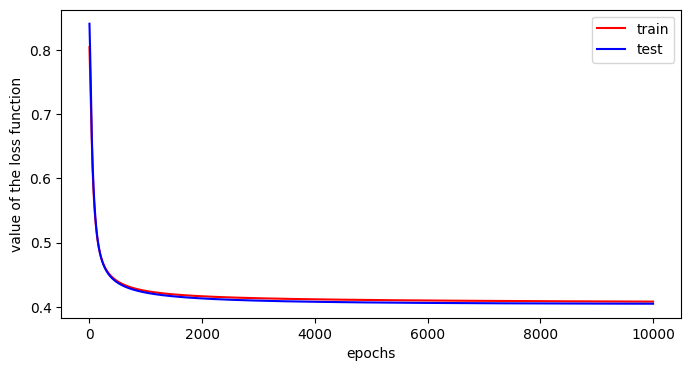

In [ ]:
# parameters for the optimization
tau = 0.1
niter = 10000

# keep track of the values of the loss function
Ls = np.zeros((niter,1))
Ls_test = np.zeros((niter,1))
for it in np.arange(0,niter):
    # save the value of the loss function at the beginning of each epoch
    [Ls[it],gW,gb] = ForwardBackwardNN(W,b,x,y)
    # compute the loss of the test set
    a = ForwardNN(W,b,x_test,L)
    Ls_test[it] = Loss(y_test,a[-1])
    # update all parameters using the gradient which was computed
    for l in np.arange(0,L):
        W[l] = W[l] - tau*gW[l]
        b[l] = b[l] - tau*gb[l]

# plot the results
plt.figure(figsize=(8,4))
plt.plot(Ls,color='red',label='train')
plt.plot(Ls_test,color='blue',label='test')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.axis('tight')
plt.legend()
plt.show()

We next evaluate the quality of the so-obtained network for classification. We generate to this end a test set of point $z_i \in \RR^2$ on a grid.

In [ ]:
nb_points_grid = 100
t = np.linspace(0,1,nb_points_grid)
# a mesh is conveniently generated using the function 'meshgrid'
# see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
[U,V] = np.meshgrid(t,t)
# the so-obtained x and y values of the points composing the 2D grid are then stacked as a column vector
# in order to evalue the function at these points
z = np.vstack([V.flatten(), U.flatten()])

We compute the classification "probability" at each location $z$, obtained from the formula $\displaystyle \sigma(\phi_\theta(x)) = \frac{\exp(\phi_\theta(x))}{1+\exp(\phi_\theta(x))}$.

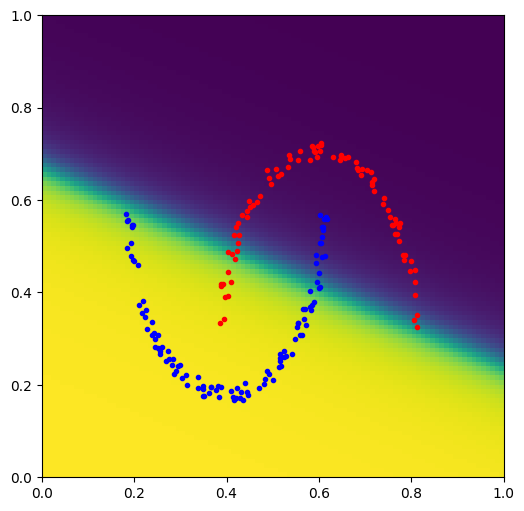

In [ ]:
def phi(r):
    return np.exp(r)/(1+np.exp(r))

# evaluate the neural network at the points of the grid (stacked vertically)
V = ForwardNN(W,b,z,L)
# reshape the so-obtained function to plot it
U = np.reshape( phi(V[L].T), [nb_points_grid,nb_points_grid] )

# plot of the probabilities estimated with the neural network
plt.figure(figsize=(6,6))
plt.imshow(U.T, origin="lower", extent=[0,1,0,1])
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' )
plt.show()

**Question 5.** Test the performance of the final network as a function of the number of training steps. Vary also the number of layers and check the influence of the topology.

# Automatic differentiation

Instead of computing the gradient "by hand", we use an automatic differentation toolbox, such as [AutoGrad](https://github.com/HIPS/autograd). It uses reverse mode automatic differentation to compute the gradient at the same expense at computing the function itself.
See [this tutorial for more information](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation).

Autograd is no longer actively maintained, the automatic differentiation tool of JAX being nowadays the reference; see https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

In [ ]:
# using autograd
import autograd.numpy as np
import autograd as ag
from autograd import elementwise_grad as egrad # for functions that vectorize over inputs; grad otherwise

# using JAX
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

We test the automatic differentiation on a scalar valued function of a single variable, by computing and plotting higher-order derivatives.

**Question 6.** Complete the code below to cross check automatic differentiation with a finite difference approximation for the first and second derivative.

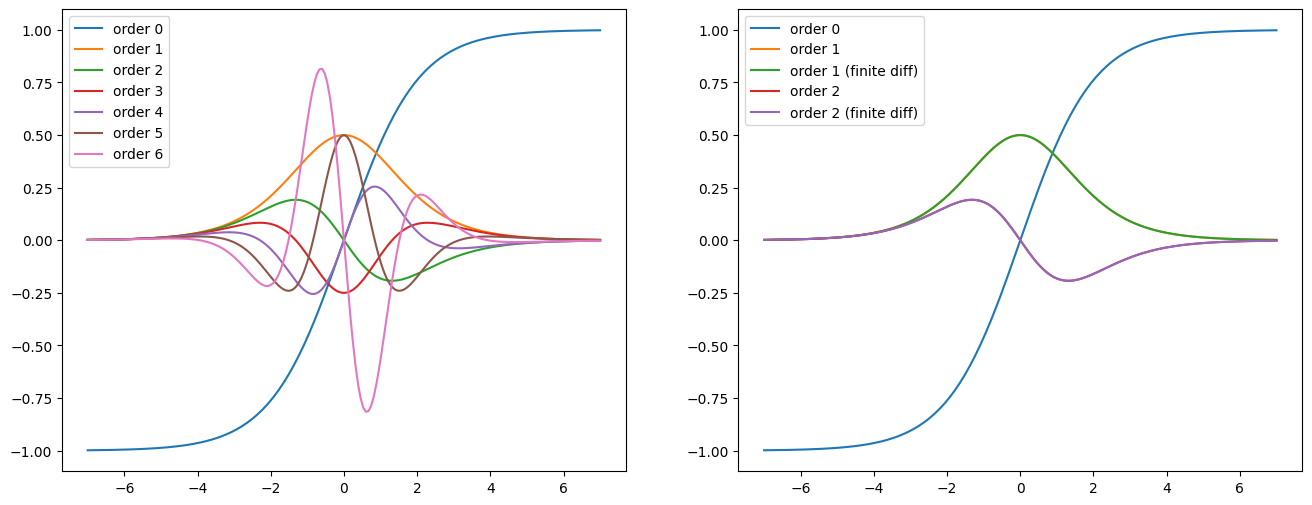

In [ ]:
# define function for numpy
def tanh(x):
    return (1.0 - np.exp(-x))  / (1.0 + np.exp(-x))

# define function for numpy in JAX
def jtanh(x):
    return (1.0 - jnp.exp(-x))  / (1.0 + jnp.exp(-x))

# range for the function
t = np.linspace(-7, 7, 200)
# to compare with finite difference approximation
eps = 10**(-6)

fig = plt.figure(figsize=(16,6))
# with Autograd
ax0 = fig.add_subplot(1, 2, 1)
ax0.plot(t, tanh(t),label='order 0')
ax0.plot(t, egrad(tanh)(t),label='order 1')                                     # first derivative
ax0.plot(t, egrad(egrad(tanh))(t),label='order 2')                              # second derivative
ax0.plot(t, egrad(egrad(egrad(tanh)))(t),label='order 3')                       # third derivative
ax0.plot(t, egrad(egrad(egrad(egrad(tanh))))(t),label='order 4')                # fourth derivative
ax0.plot(t, egrad(egrad(egrad(egrad(egrad(tanh)))))(t),label='order 5')         # fifth derivative
ax0.plot(t, egrad(egrad(egrad(egrad(egrad(egrad(tanh))))))(t),label='order 6')  # sixth derivative
ax0.legend()
# with JAX + comparison with finite differences
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(t, tanh(t),label='order 0')
# vmap used to vectorize operations
# see https://www.kaggle.com/code/aakashnain/tf-jax-tutorials-part-9-autodiff-in-jax#Gradients
d1_tanh = grad(jtanh)
d1_values = vmap(d1_tanh)(t)
ax1.plot(t, d1_values,label='order 1')
ax1.plot(t,(tanh(t+eps)-tanh(t-eps))/(2*eps),label='order 1 (finite diff)')
d2_tanh = grad(d1_tanh)
d2_values = vmap(d2_tanh)(t)
ax1.plot(t, d2_values,label='order 2')
ax1.plot(t,(tanh(t+eps)-2*tanh(t)+tanh(t-eps))/eps**2,label='order 2 (finite diff)')
ax1.legend()
plt.show()

We can next consider functions of several variables, for instance the quadratic function $\displaystyle f(u)=\frac12 u^\top M u$ for $M$ symmetric, whose gradient is $\nabla f(u)=Mu$.

In [ ]:
# construct a random symmetric matrix
M = np.random.randn(3,3)
M = M+M.T

# quadratic function
def f(u):
    return np.sum( .5 * u.T @ (M@u) )

# evaluation of the gradient at a random point; simply 'grad' here since no vectorization
u = np.random.randn(3,1)
g = ag.grad(f)
print('Difference between analytic gradient and autograd: ' + str( np.linalg.norm(np.abs((g(u) - M@u) ) )))

Difference between analytic gradient and autograd: 0.0


We next consider the loss function $f(\theta)$ to be minimized for classification using neural networks, with $\theta=(W,b)$.

In [ ]:
def FuncNN(theta):
    a = ForwardNN(theta[0],theta[1],x,L)
    return Loss(y,a[-1])

In [ ]:
D = [2, 4, 5, 8, 1]
L = np.size(D)-1
W = []
b = []
for l in np.arange(0,L):
    W.append(np.random.randn(D[l+1],D[l]))
    b.append(np.random.randn(D[l+1],1))

We compute the function and its gradient.

In [ ]:
FuncNNG = ag.value_and_grad(FuncNN)
tht = (W,b)
[u,g] = FuncNNG(tht)
gW = g[0] # gradient with respect to A
gb = g[1] # gradient with respect to b

**Question 7.** Compare the gradient computed by automatic differentiation and the one computed "by hand" using backpropagation (show for instance that the norm of the difference is of the order of machine precision).

In [ ]:
[Ls,gW1,gb1] = ForwardBackwardNN(W,b,x,y)
e = 0
for l in range(L):
    e += np.linalg.norm(gW[l]-gW1[l])
    e += np.linalg.norm(gb[l]-gb1[l])
print('Difference between backpropagation and autograd: ',e)

Difference between backpropagation and autograd:  1.2060647475698293e-17


# Automatic differentiation using *PyTorch*

Pytorch is a powerful deep learning library whose main feature is to perform automatic differentiation. One caveat is that one need to manipulate PyTorch tensors in place of Numpy arrays. An avantage with respect to AutoGrad is that it contains higher level primitive which allows to hide from the user the parameter of the layer (e.g. linear weights and bias). See https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html# for an introduction.

In [ ]:
import torch
import torch.nn as nn

We first define the architecture. You can try `nn.ReLu()` in place of `nn.Tanh()` to obtain straight boundaries. One can try one of the two following cell depending of the number of hidden layers you want (there are more automatic ways to code this up but we keep a simple version here).

In [ ]:
D = [2, 4, 5, 8, 4, 1]
model = nn.Sequential(
      nn.Linear(D[0], D[1]),
      nn.Tanh(),
      nn.Linear(D[1], D[2]),
      nn.Tanh(),
      nn.Linear(D[2], D[3]),
      nn.Tanh(),
      # could add dropout somewhere with an additional line like: nn.Dropout(0.1),
      nn.Linear(D[3], D[4]),
      nn.Tanh(),
      nn.Linear(D[4], D[5]),
)

In [ ]:
D = [2, 20, 1]
model = nn.Sequential(
      nn.Linear(D[0], D[1]),
      nn.Tanh(),
      nn.Linear(D[1], D[2]),
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=1, bias=True)
)


We first initialize the weights with  Gaussian random variables using the dedicated PyTorch routine https://pytorch.org/docs/stable/nn.init.html

In [ ]:
L = np.size(D)-1
for l in range(0,L):
    print('Initializing model[',2*l,']')
    nn.init.normal_(model[2*l].bias, 0, 1)
    nn.init.normal_(model[2*l].weight, 0,1)

Initializing model[ 0 ]
Initializing model[ 2 ]


We next convert arrays into PyTorch tensors. See here for a more complete discussion of these classes https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html Beware that for PyTorch the data should be of size $(n,2)$ so that we apply the function *model* to it, which is why we need to transpose the tensors.

In [ ]:
X = torch.Tensor(x).T
Y = torch.Tensor(y).T
X_test = torch.Tensor(x_test).T
Y_test = torch.Tensor(y_test).T
print("Data shape:",X.shape)

Data shape: torch.Size([200, 2])


We first run the forward pass and evaluate the loss function.

In [ ]:
loss = 1/n * torch.sum( -torch.log( torch.sigmoid(-model(X)*Y) ) )
# printing the loss: tensor of a single element, hence using .item() to access this element
print( loss.item() )

0.641460657119751


We next run the backward pass to evaluate the gradients of all the parameters involved in the model.

In [ ]:
model.zero_grad()
loss.backward()

We can then perform one step of the gradient method to update each parameter as $\theta \leftarrow \theta - \tau \nabla f(\theta)$.

In [ ]:
tau = .5
# use no_grad in order to update parameters
# this way, they keep the "requires_grad=True" flag, which is fundamental to automatically compute the gradient
# you can compare what happens when changing the update rule to "theta -= tau * theta.grad"
# or when torch.no_grad() is commented out
# in both cases, tensor(..., requires_grad=True) is transformed into something different
# e.g. tensor(...) or tensor(..., grad_fn=<SubBackward0>)
with torch.no_grad():
    for theta in model.parameters():
        # to see the type before: print(theta)
        theta = theta - tau * theta.grad
        # to see the type after: print(theta)

Gradient descent can finally be obtained by putting all these elementary steps together. We do not do any form of regularization here, even early stopping. This will be needed in actual applications (see the next notebook).

**Question 8.** Compare the results obtained with various parameters of the model (in particular architecture and activation functions) and of the optimization function. Note that this comparison cannot be too quantitative since we would need to implement early stopping in order to stop optimization when necessary.

In [ ]:
# parameters
tau = .1
niter = 20000

# initialization of the vector of values of the loss functions
Ls = np.zeros((niter,1))
Ls_test = np.zeros((niter,1))

# iterations over the epochs
for i in range(niter):
    loss = 1/n * torch.sum( -torch.log( torch.sigmoid(model(X)*Y) ) )
    Ls[i] = loss.item()
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        loss = 1/n * torch.sum( -torch.log( torch.sigmoid(model(X_test)*Y_test) ) )
        Ls_test[i] = loss.item()
        for theta in model.parameters():
            theta -= tau * theta.grad

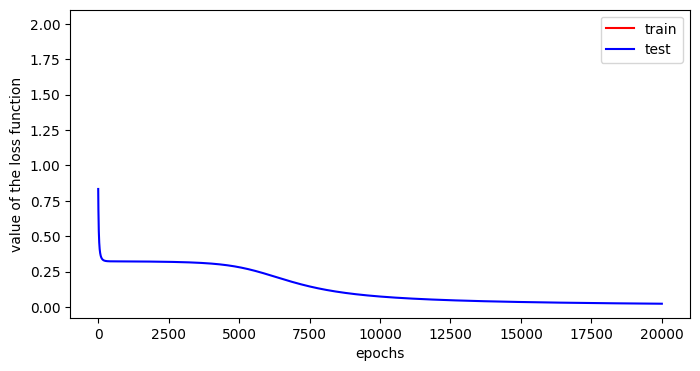

In [ ]:
# plotting the results
plt.figure(figsize=(8,4))
plt.plot(L,color='red',label='train')
plt.plot(Ls_test,color='blue',label='test')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.axis('tight')
plt.legend()
plt.show()

We can finally vizualize the application of the network on the grid points defined by `z`.

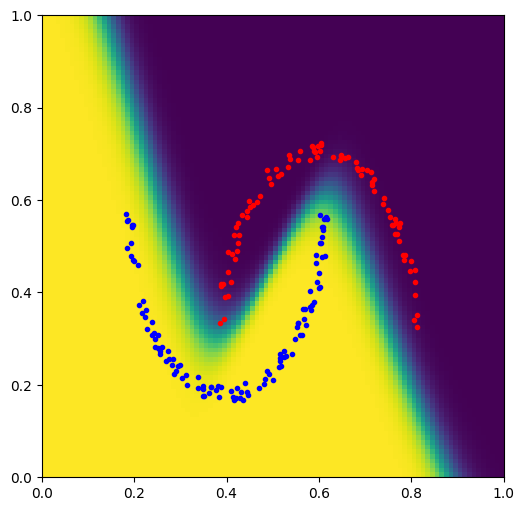

In [ ]:
# evaluate the neural network at the grid points
V = model(torch.Tensor(z).T)
# convert back to numpy array
V = V.detach().numpy()
# reshape the so-obtained function to plot it
U = np.reshape( phi(V), [nb_points_grid,nb_points_grid] )

# plot of the probabilities estimated with the neural network
plt.figure(figsize=(6,6))
plt.imshow(U.T, origin="lower", extent=[0,1,0,1])
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' )
plt.show()